In [1]:
DATASET = 'scales_full'
OUTNAME = 'SAGE'
NPERMS = 10
DIFFICULTY_BINS = 10

In [2]:
import sys
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch_geometric.transforms as T
from torch_geometric.nn import to_hetero
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
import gc
from sklearn.manifold import TSNE
import seaborn as sns
from cluster_utils import evaluate_items
from vis_utils import (visualize_students, visualize_edges_age, visualize_edges, visualize_items, myresults, FIGSIZE,
CLUSTER_LABELS,  AGE_THR, DPI, CPU_Unpickler, plot_clustering, FONTSCALE)

sns.set_theme(context='talk', style='white', font_scale=FONTSCALE)

FILENAME = f'{OUTNAME}_{DATASET}'
EQUAL_AXES=False
MINSAMPLES = 10 #if DATASET in ['matrix', 'topic'] else 10

RELOAD = False

In [3]:
torch.cuda.empty_cache()
device = 'cpu'
model = torch.load(f'./results/{FILENAME}.pth.tar', map_location=torch.device('cpu'))

In [ ]:
with open(f'./results/{FILENAME}_aux_data.pkl', 'rb') as handle:
    aux_data = CPU_Unpickler(handle).load()
    
(df, df_student, df_item, df_edge, 
            train_losses, #test_losses, test_aucs,
            train_edge_indices, val_edge_indices, test_edge_indices, 
            data, train_data, val_data, test_data,
            unique_scales, unique_domains, unique_matdiff, 
            DATA_FILE) = aux_data
print(df_item.shape)

try:
    # if IRT data exists, take item parameters
    with open(f'./results/IRT_{DATASET}_aux_data_IRT1.pkl', 'rb') as handle:
        aux_data = CPU_Unpickler(handle).load()

    (_, _, df_item, *_) = aux_data
except:
    pass
print(df_item.shape)

(35087, 8)


In [ ]:
if RELOAD:
    df = load_data_heterogeneous(DATA_FILE)
    data, df_student, df_item, df_edge = create_data_object_heterogeneous(df)

In [ ]:
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())
fig = plt.figure()
age_ranges.plot.hist(bins=100)
plt.show()

fig = plt.figure()
df.age.plot.hist(bins=100)
age_ranges = df.groupby('studentId').age.apply(lambda x: x.max() - x.min())

plt.show()

In [ ]:
# different items per student
df.groupby(['studentId']).code.nunique().hist(bins=100)
df.groupby(['studentId']).code.nunique().median()


10.0

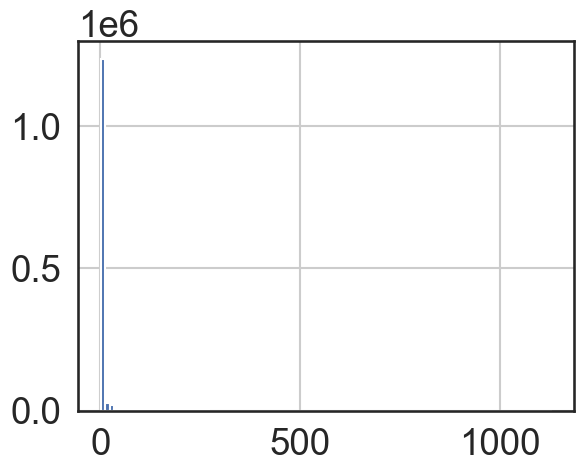

In [8]:
df.groupby(['assessmentId']).code.nunique().hist(bins=100)
df.groupby(['assessmentId']).code.nunique().median()

In [9]:
age_ranges.mean()

1.2189035417825627

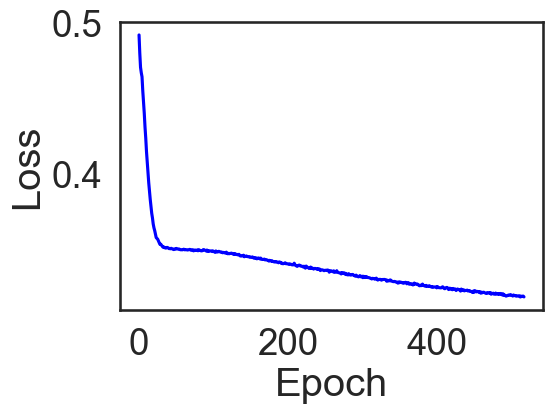

In [10]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_losses.png', dpi=DPI)

In [11]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
1,0,1,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
2,0,2,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
3,0,3,1.0,0.0,fhoe,F.1.A.1.c.1,-0.37033,Monologe und Dialoge,NaN,NaN,...,7.830814e-312,ms-kber,85007E334A2C9F19ECA408647E6F97139649B1465E15EB...,1.083005,1.851849,2,1.08,,,f
4,0,4,1.0,0.0,fles,F.2.A.1.b.3,-0.49488,Berichte,NaN,NaN,...,7.833807e-312,ms-thema-auto,0D59C4843FFC39195EDE1DD140506CF3DF8BC6F132AAF5...,0.657010,2.727266,3,1.10,,,f


df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)

df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()


In [12]:
from scipy.stats import pearsonr
pearsonr(df_item['IRT1_difficulty'], df_item['IRT1_discrimination_transf'])

PearsonRResult(statistic=-0.13864778695233174, pvalue=4.043165259355576e-150)

plot_clustering('scalexdifficulty', 'matrix', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
plot_clustering('scalexdifficulty', 'topic', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)


if DATASET in ['matrix', 'topic']:
    sys.exit()

In [13]:
myresults.output_stats()

E.5.D.1.c      61
E.5.D.1.d      54
E.5.D.1.c.1    52
E.5.B.1.c      26
E.5.E.2.c.2    23
E.5.D.1.b      22
E.5.D.1.d.1    22
E.5.E.2.b      21
E.5.E.2.a.1    21
E.5.D.1.a      15
E.5.D.1.b.1    13
E.5.B.1.d      13
E.5.E.2.c      11
E.5.D.1.d.2     9
E.5.D.1.c.2     9
E.5.B.1.e       7
E.5.B.1.b       6
E.5.E.2.a       2
E.5.D.1.a.2     2
E.5.E.2.c.1     1
E.5.B.1.a       1
Name: matrix, dtype: int64
E.5.D.1.c      61
E.5.D.1.d      54
E.5.D.1.c.1    52
E.5.B.1.c      26
Name: matrix, dtype: int64


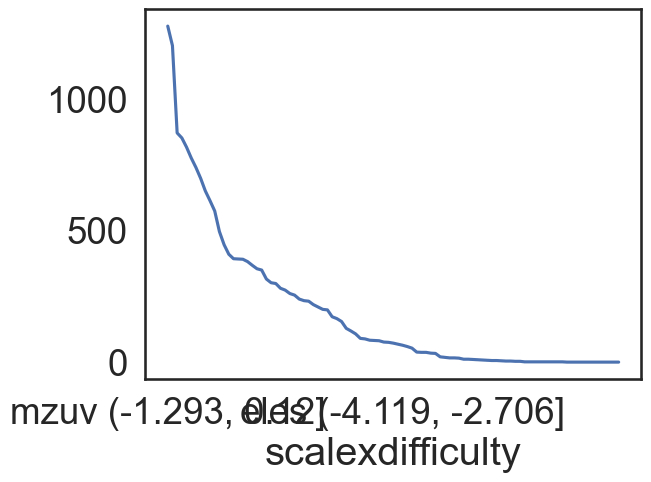

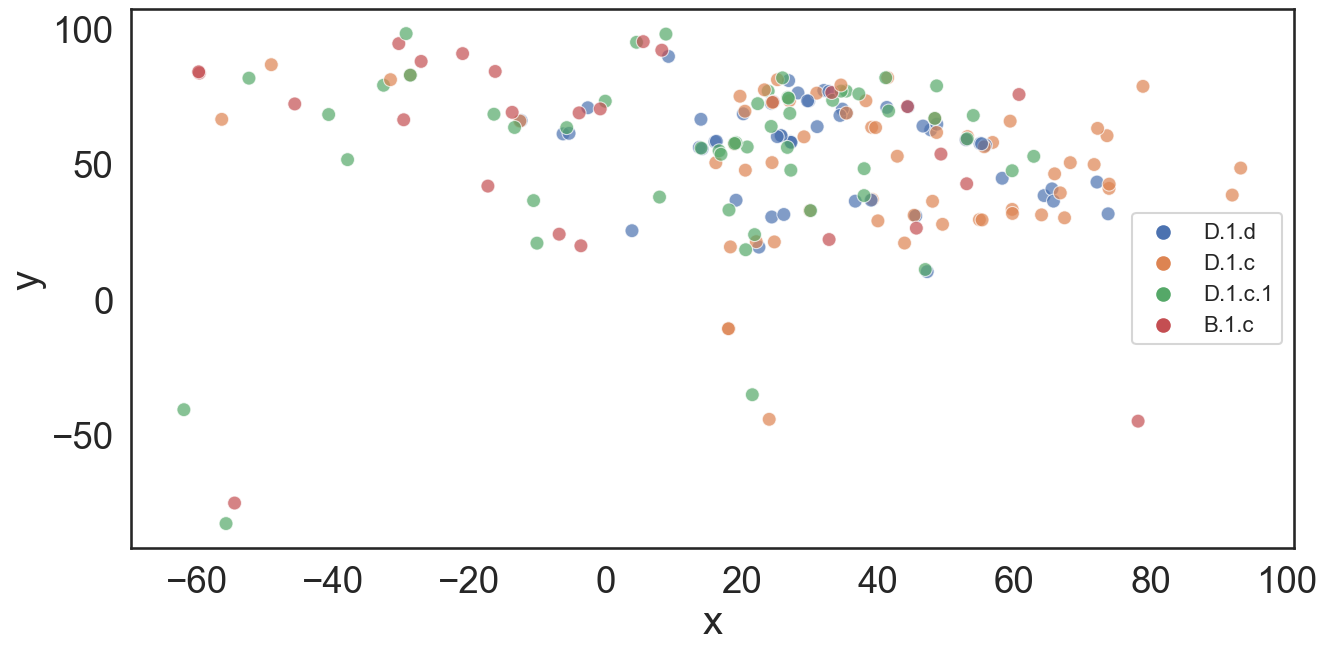

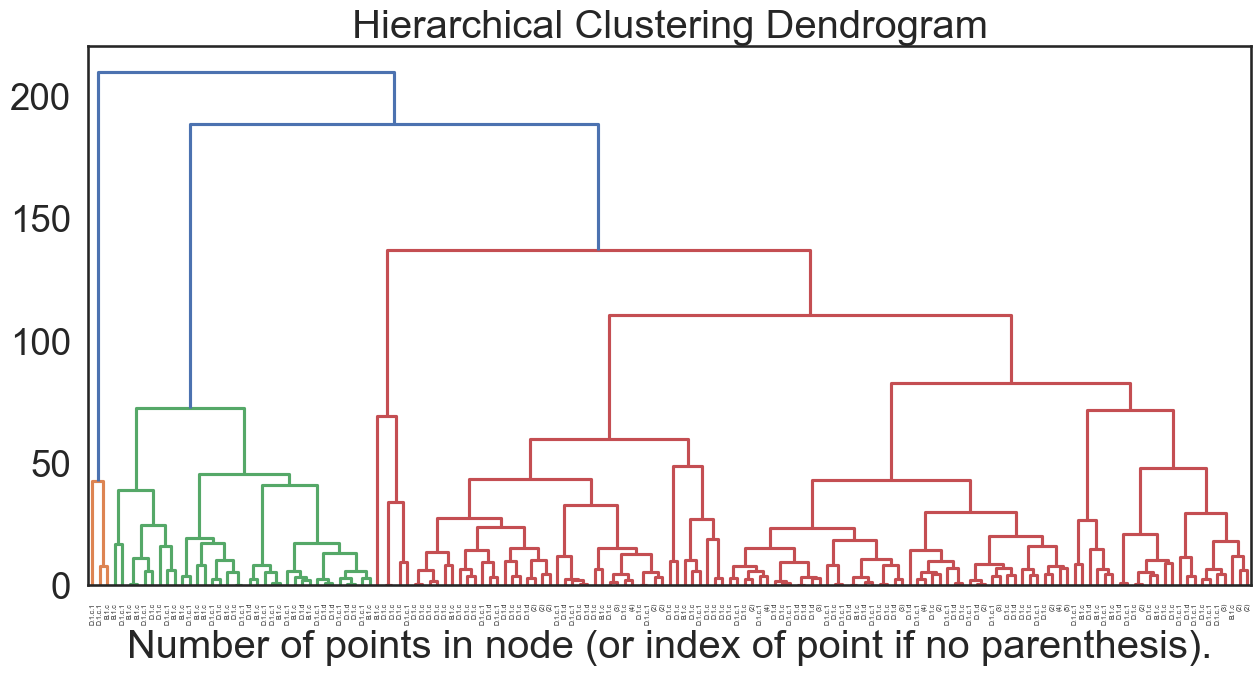

MA.3.C.2.d.1    54
MA.3.A.3.h.2    37
MA.3.B.2.b.1    31
MA.3.A.1.i.2    31
MA.3.A.2.h.1    27
                ..
MA.3.A.2.g       1
MA.3.A.2.j       1
MA.3.C.1.j       1
MA.3.A.2.k       1
MA.3.C.2.d       1
Name: matrix, Length: 78, dtype: int64
MA.3.C.2.d.1    54
MA.3.A.3.h.2    37
MA.3.A.1.i.2    31
MA.3.B.2.b.1    31
Name: matrix, dtype: int64


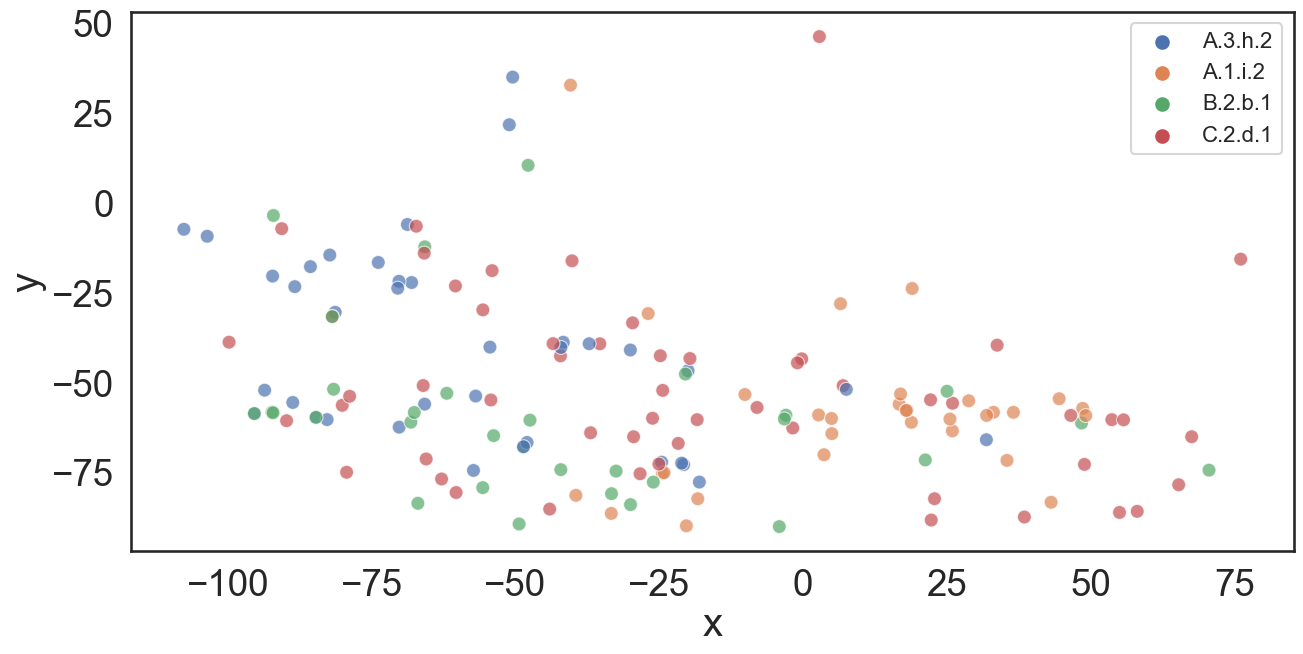

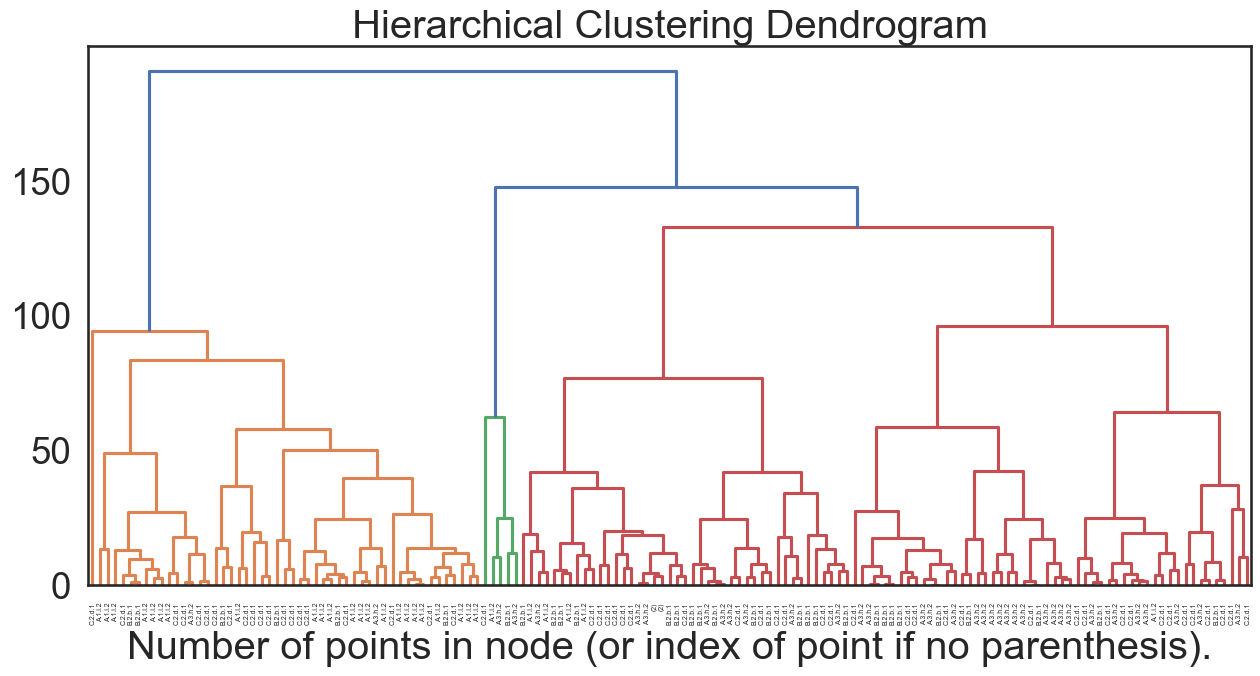

MA.2.A.2.f.1    35
MA.2.A.3.h.1    33
MA.2.B.1.g.1    31
MA.2.A.3.g.3    30
MA.2.A.3.i.1    26
                ..
MA.2.C.3.d       1
MA.2.A.3.i       1
MA.2.B.2.b.1     1
MA.2.A.2.h.2     1
MA.2.B.1.l       1
Name: matrix, Length: 67, dtype: int64
MA.2.A.2.f.1    35
MA.2.A.3.h.1    33
MA.2.B.1.g.1    31
MA.2.A.3.g.3    30
Name: matrix, dtype: int64


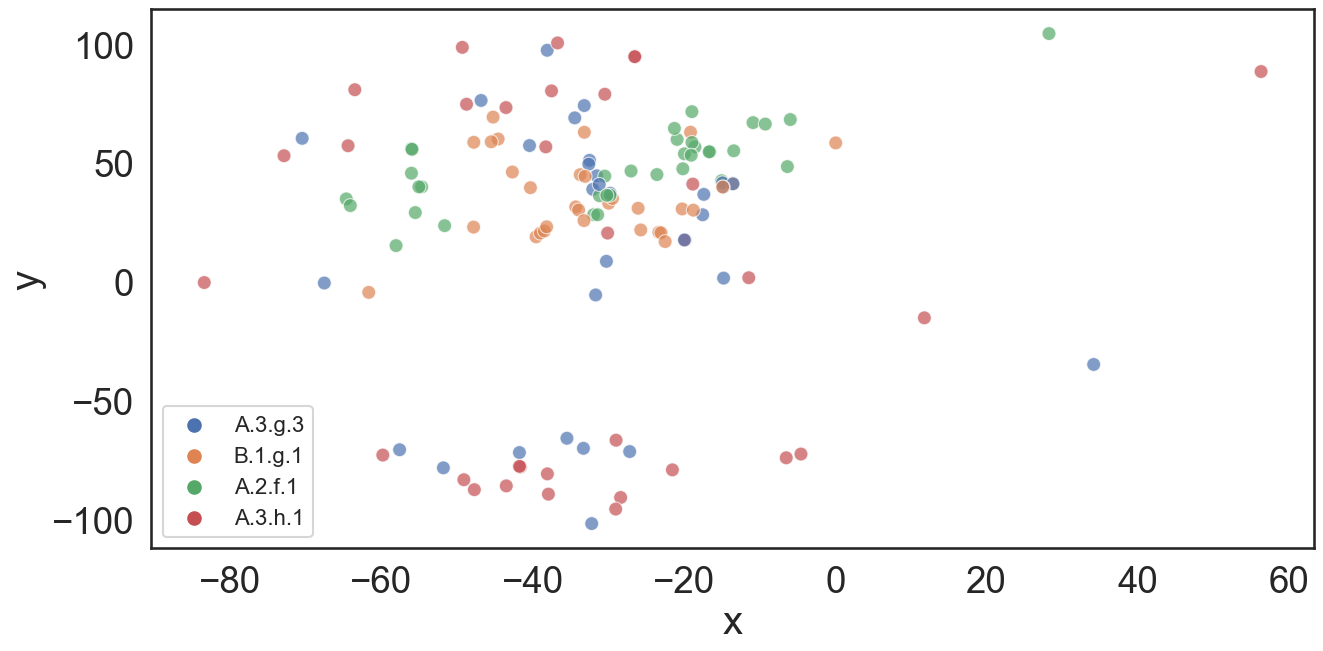

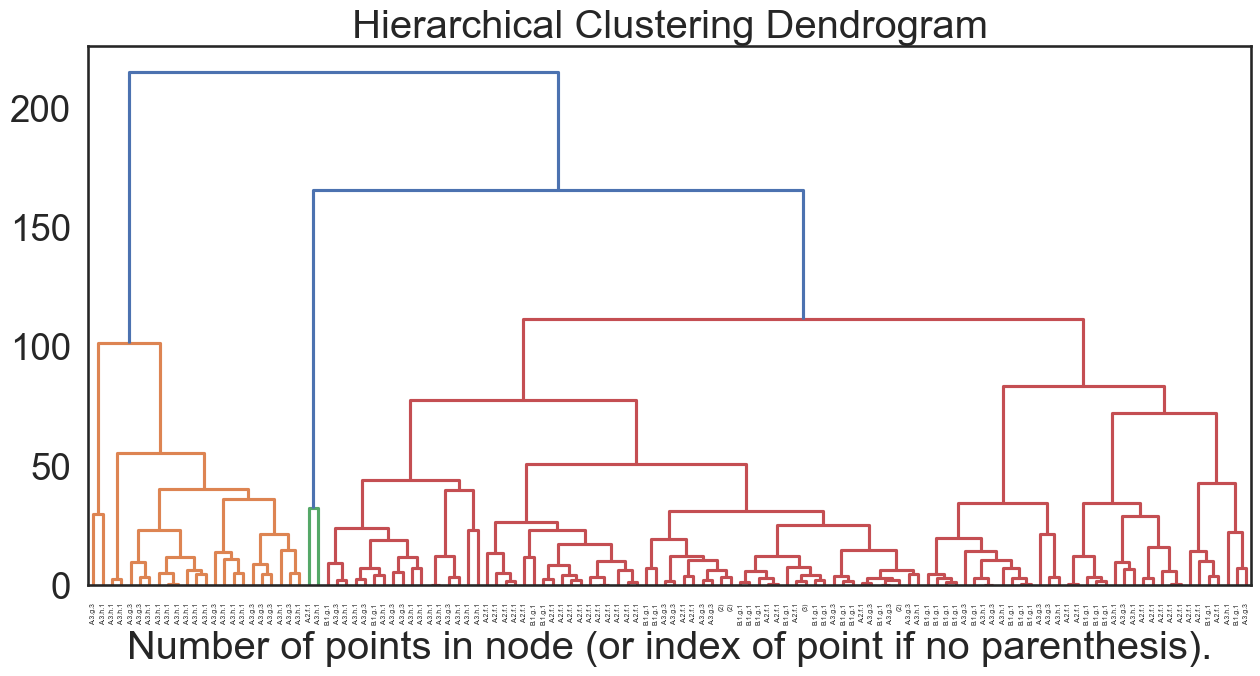

MA.1.B.1.j.2    45
MA.1.A.3.i.2    42
MA.1.A.4.k.1    37
MA.1.B.1.h.2    33
MA.1.B.2.f.1    31
                ..
MA.1.A.2.h.1     1
MA.1.A.3.e.2     1
MA.1.B.2.k       1
MA.1.C.2.g       1
MA.1.A.4.g       1
Name: matrix, Length: 99, dtype: int64
MA.1.B.1.j.2    45
MA.1.A.3.i.2    42
MA.1.A.4.k.1    37
MA.1.B.1.h.2    33
Name: matrix, dtype: int64


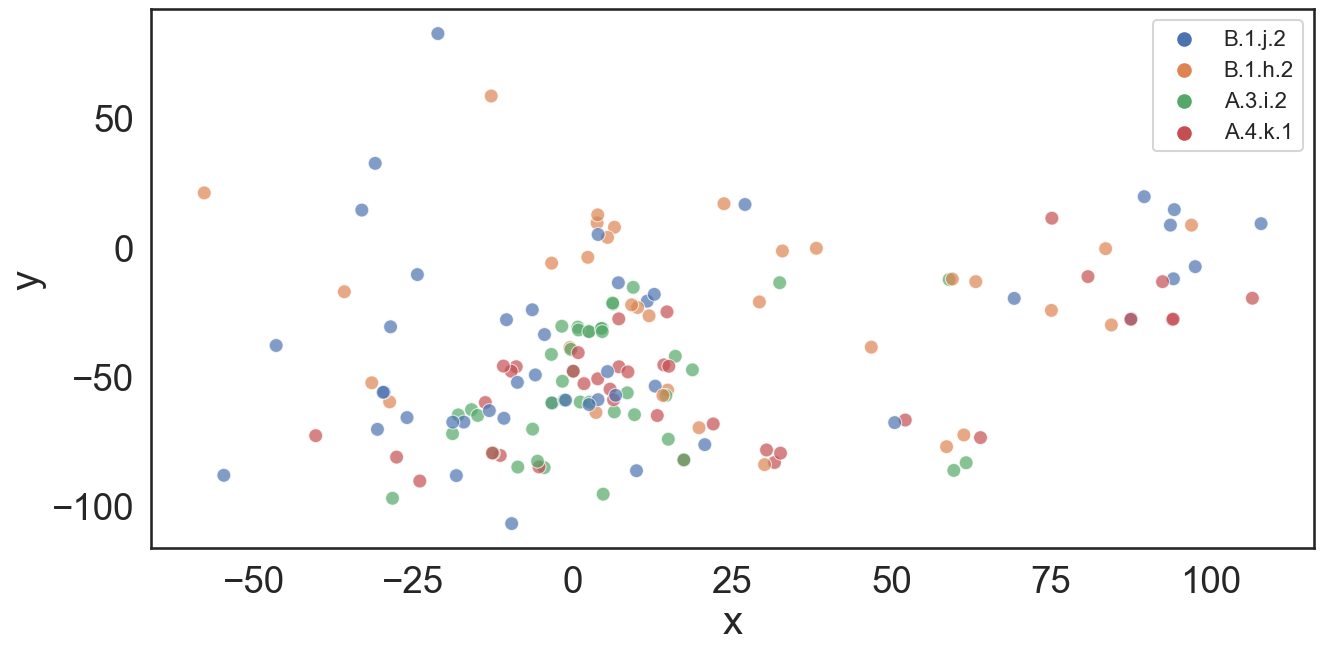

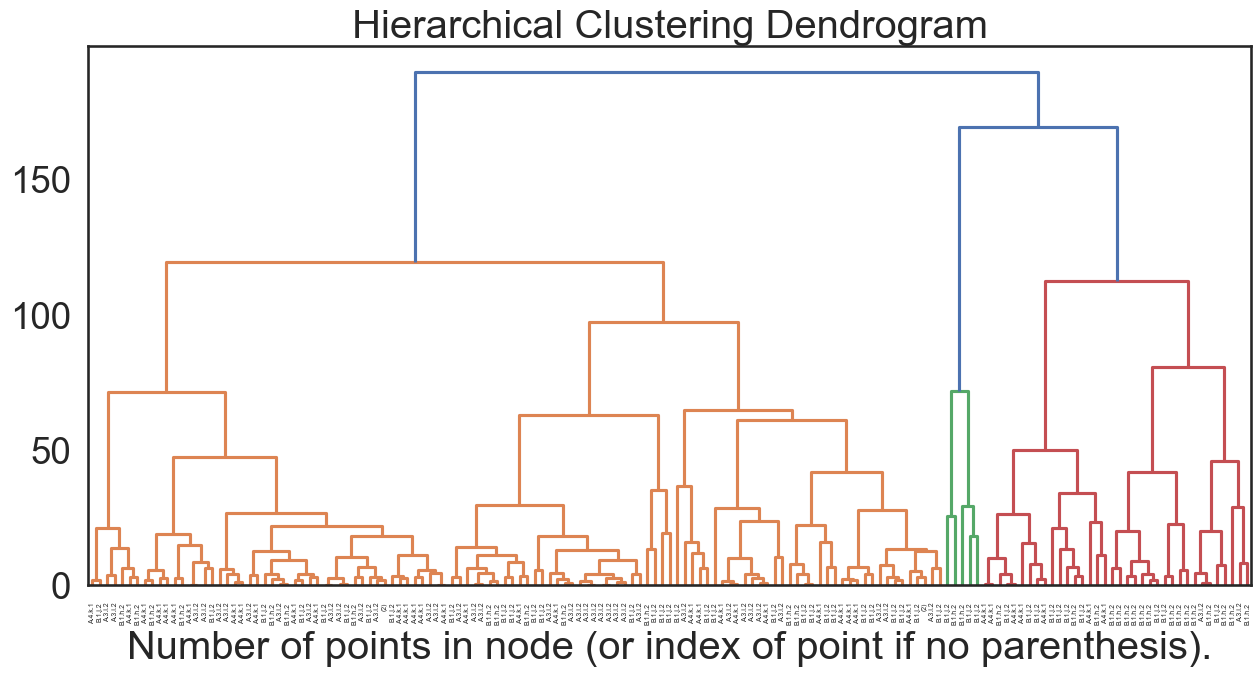

In [14]:
minlevels = 8
MINSAMPLES = 20
from cluster_utils import compute_clustering_indices
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

dimred = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
#dimred = PCA(whiten=False)

df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                         
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)
df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()


grouping_variable, target_variable = 'scalexdifficulty', 'matrix'
scores_dict = {'CH': [], 'DB':[], 'N_LEVELS':[], 'N_SAMPLES':[]}
scores = compute_clustering_indices(model, train_data, df_item.copy(), device, grouping_variable, 
                                        target_variable, shuffle=False, seed=0, minsamples=MINSAMPLES)
[ scores_dict[key].append(scores[key]) for key in scores_dict]

scores_df = pd.DataFrame(scores_dict['DB'])        
scores_df = pd.melt(scores_df, value_name='index', var_name=grouping_variable).sort_values('index', ascending=False)

scores_df['N_LEVELS'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_LEVELS'][0][x])
scores_df['N_SAMPLES'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_SAMPLES'][0][x])

scores_df = scores_df.loc[scores_df['N_LEVELS'] >= minlevels]


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, scores_df, k=0):
    df_item_ = df_item.reset_index().drop(columns='index')

    df_item_sub = df_item_.loc[df_item_[grouping_variable] == scores_df.iloc[k][grouping_variable]]
    
    # look only at those with a minimum of samples
    tab = df_item_sub[target_variable].value_counts()
    print(tab)
    #ind = tab[tab >= minsamples].index
    ind = tab[:4].index
    df_item_sub = df_item_sub.loc[df_item_sub[target_variable].isin(ind).values]
    if target_variable == 'matrix':
        df_item_sub['labels'] = df_item_sub[target_variable].apply(lambda x: '.'.join(x.split('.')[2:]))
    else:
        df_item_sub['labels'] = df_item_sub[target_variable]
    print(df_item_sub[target_variable].value_counts())
    data = data.to(device)

    z_dict = model.get_embeddings(data, encoded=True)
    embedding = z_dict['item'].detach().cpu().numpy()
    #dimred.fit(embedding)
    #low_dim = dimred.transform(embedding)

    low_dim = dimred.fit_transform(embedding)
    low_dim = low_dim[df_item_sub.index, :]

    X = df_item_sub #.loc[select, :]

    #X['domain'] = X['domain'].apply(lambda x: DOMAIN_LABELS[x])

    X['x'] = low_dim[:, 0]
    X['y'] = low_dim[:, 1]
     #   X['z'] = low_dim[:, 2]

    fig = plt.figure(figsize=(15, 7))
    axes = sns.scatterplot(data=X, x='x', y='y', hue='labels', s=100, alpha=0.7) 
    axes.legend(prop = { 'size': 16 })
    plt.show()

    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
    clustering.fit(low_dim)

    fig = plt.figure(figsize=(15, 7))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram

    plot_dendrogram(clustering, truncate_mode="level", p=10, labels=df_item_sub['labels'].values)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    
for k in range(4):
    plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, scores_df, k=k)


In [15]:
scores_df


,scalexdifficulty,index,N_LEVELS,N_SAMPLES
24,"esif (-1.293, 0.12]",0.176524,9,302
50,"mgfz (0.12, 1.533]",0.173522,12,335
33,"mfur (0.12, 1.533]",0.173420,10,266
6,"mzuv (0.12, 1.533]",0.145824,11,330
42,"mgfz (-1.293, 0.12]",0.144021,12,374
19,"eles (-1.293, 0.12]",0.123486,11,320
9,"mzuv (-1.293, 0.12]",0.118374,24,691
31,"mfur (-1.293, 0.12]",0.114398,9,240
18,"dsif (-2.706, -1.293]",0.112394,12,577
32,"dles (-1.293, 0.12]",0.109777,12,470


# represent embeddings before and after the GNN encoder
visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=True)

In [16]:
scores_dict = {
    'matrix':{'CH': [], 'SH': [], 'DB':[]},
    'topic':{'CH': [], 'SH': [], 'DB':[]}
    }
distances_dict = {'within': [], 'between': []}
mean_distance_list = []
#NPERMS = 10
# perm == 0 is unshuffled
for perm in range(NPERMS):
    scores_matrix, scores_topic, within_domain, between_domain, mean_distances, unique_scales, within_between_scales = evaluate_items(model, train_data, df_item, device, 
                                                                           shuffle=perm>0, 
                                                                           seed=0, 
                                                                           minsamples=MINSAMPLES)
    
    [ scores_dict['matrix'][key].append(scores_matrix[key]) for key in scores_dict['matrix']]
    [ scores_dict['topic'][key].append(scores_matrix[key]) for key in scores_dict['topic']]
    distances_dict['within'].append(within_domain)
    distances_dict['between'].append(between_domain)
    mean_distance_list.append(within_between_scales)

dsif    6813
mzuv    6421
mgfz    4801
mfur    3479
dles    3130
esif    2507
fsif    2213
eles    1918
ehoe    1491
fles    1383
fhoe     931
Name: scale, dtype: int64
dles    500
dsif    500
ehoe    500
eles    500
esif    500
fhoe    500
fles    500
fsif    500
mfur    500
mgfz    500
mzuv    500
Name: scale, dtype: int64


In [17]:
distances_df = pd.DataFrame(np.concatenate(mean_distance_list), columns=unique_scales) 
distances_df['perm'] = distances_df.index // len(unique_scales)
distances_df['random'] = 'Observed\n data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled\n data'
distances_df['within_between'] = 'between'
distances_df.loc[ distances_df.index % len(unique_scales) == 0, 'within_between'] = 'within'

distances_df = distances_df.groupby(['perm','within_between','random'])[unique_scales].mean().reset_index()
distances_df = pd.melt(distances_df, id_vars=['perm','within_between','random'], value_name='distance', var_name='scale')

# between - within distance should be positive
distances_df['diff'] = distances_df['distance'] 
aux = distances_df.query('`within_between` == "between"').copy().reset_index()
within = distances_df.query('`within_between` == "within"').reset_index()['distance']
aux['diff'] = (aux['diff'] - within)/within*100

distances_df = aux.drop(columns='within_between').sort_values(by=['scale', 'random'])


In [18]:
distances_df.query('perm == 0' )

,index,perm,random,scale,distance,diff
70,140,0,Observed\n data,dles,6.046852,45.578666
30,60,0,Observed\n data,dsif,5.760778,53.717290
90,180,0,Observed\n data,ehoe,6.152156,37.339552
60,120,0,Observed\n data,eles,6.249400,26.478893
40,80,0,Observed\n data,esif,6.915509,3.379577
0,0,0,Observed\n data,fhoe,6.396154,15.292396
10,20,0,Observed\n data,fles,5.916575,39.820176
50,100,0,Observed\n data,fsif,6.012912,21.543788
80,160,0,Observed\n data,mfur,7.306483,6.784866
100,200,0,Observed\n data,mgfz,7.365365,6.229339


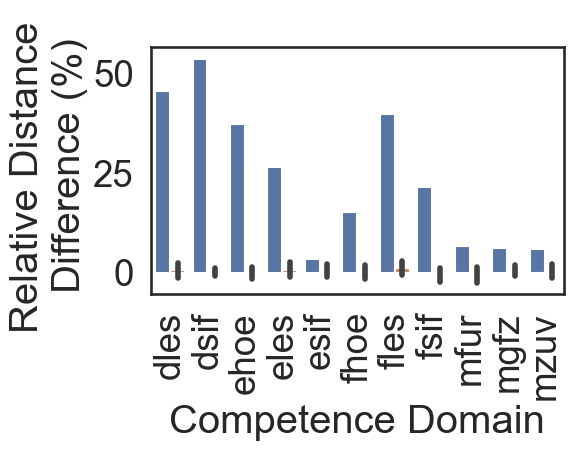

In [19]:
fig = plt.figure()
axes = sns.barplot(data=distances_df, x='scale', y='diff', hue='random', errorbar='sd')
axes.legend_.remove()
axes.tick_params(axis='x', rotation=90)
axes.set(xlabel='Competence Domain', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()
plt.savefig(f'./vis/{FILENAME}_scale_distance_bw.png', dpi=DPI)

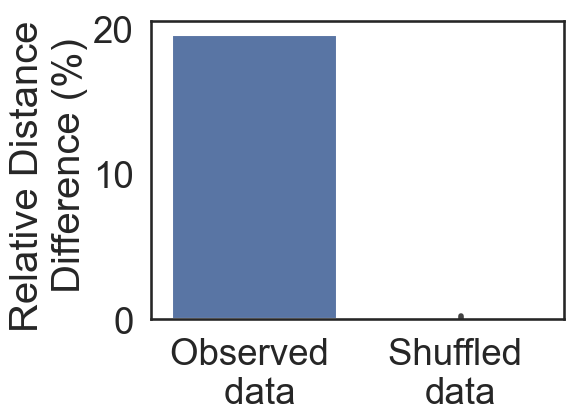

In [20]:
distances_df = pd.DataFrame(distances_dict)
distances_df['perm'] = distances_df.index
#distances_df = pd.melt(distances_df, id_vars='perm', value_name='index', var_name='group')
distances_df['random'] = 'Observed \n data'
distances_df.loc[ distances_df['perm'] > 0, 'random'] = 'Shuffled \ndata'
distances_df['diff'] = (distances_df['between'] - distances_df['within'] )/distances_df['within']*100

fig = plt.figure()
ax = sns.barplot(data=distances_df, x='random', y='diff', errorbar='sd')
ax.set(xlabel='', ylabel='Relative Distance \n Difference (%)')
fig.tight_layout()

plt.savefig(f'./vis/{FILENAME}_domain_distance_bw.png', dpi=DPI)

In [21]:
distances_df.query('perm == 0' )

,within,between,perm,random,diff
0,5.571423,6.657918,0,Observed \n data,19.501218


In [22]:
#fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#from matplotlib.category import UnitData

for variable in ['matrix']: # , 'topic'
    for i, index in enumerate(['CH', 'DB']): #scores_dict
        fig = plt.figure(figsize=(FIGSIZE))

        scores_df = pd.DataFrame(scores_dict[variable][index])
        scores_df['perm'] = scores_df.index
        scores_df = pd.melt(scores_df, id_vars='perm', value_name='index', var_name='scale')
        scores_df['random'] = 'Observed data'
        scores_df.loc[ scores_df['perm'] > 0, 'random'] = 'Shuffled data'
        #plt.figure()
        scores_df['scale'] = pd.Categorical(scores_df['scale'], categories=np.sort(scores_df.scale.unique()))
        axes = sns.barplot(data=scores_df, x='scale', y='index', hue='random', errorbar='sd')
        axes.legend_.remove()
        axes.set_xlabel('Competence Domain')
        axes.set_ylabel('Cluster Validity Index')
        axes.set_title(CLUSTER_LABELS[index])
        axes.tick_params(axis='x', rotation=90)
        fig.tight_layout()
        plt.savefig(f'./vis/{FILENAME}_{variable}_bw_random_{index}.png', dpi=DPI)
        plt.close()
        print(scores_df.query('perm == 0'))

     perm scale      index         random
0       0  fhoe   6.400322  Observed data
10      0  fles   6.154169  Observed data
20      0  mzuv  10.515311  Observed data
30      0  dsif  18.247748  Observed data
40      0  esif  16.421375  Observed data
50      0  fsif  13.546140  Observed data
60      0  eles   7.384584  Observed data
70      0  dles   8.909735  Observed data
80      0  mfur  15.282942  Observed data
90      0  ehoe  11.640569  Observed data
100     0  mgfz  10.363945  Observed data
     perm scale     index         random
0       0  fhoe  0.122360  Observed data
10      0  fles  0.108103  Observed data
20      0  mzuv  0.124623  Observed data
30      0  dsif  0.086970  Observed data
40      0  esif  0.137064  Observed data
50      0  fsif  0.119519  Observed data
60      0  eles  0.087004  Observed data
70      0  dles  0.114028  Observed data
80      0  mfur  0.122192  Observed data
90      0  ehoe  0.122950  Observed data
100     0  mgfz  0.129051  Observed data


<AxesSubplot:xlabel='scalexdifficulty'>

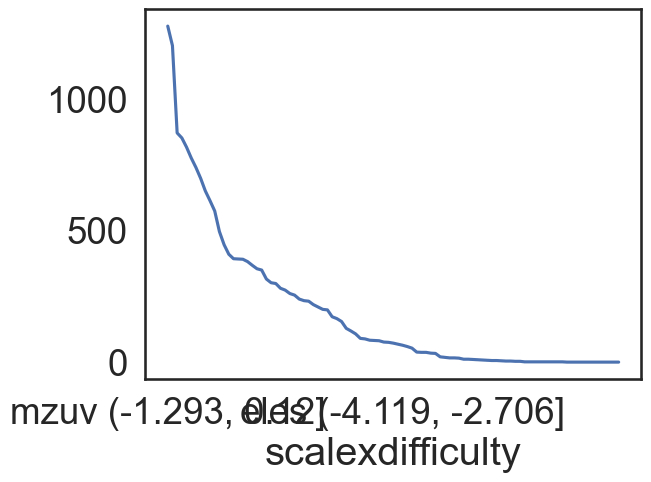

In [23]:
df_item['IRT_difficulty_binned'] = pd.cut(df_item['IRT1_difficulty'], DIFFICULTY_BINS).astype(str)
df_item['scalexdifficulty'] = df_item.apply(lambda x: x.scale + ' ' + 
                                         
                                            x.IRT_difficulty_binned if x.IRT_difficulty_binned != 'nan' else pd.NA, axis=1)
df_item.groupby('scalexdifficulty').matrix.count().sort_values(ascending=False).plot()

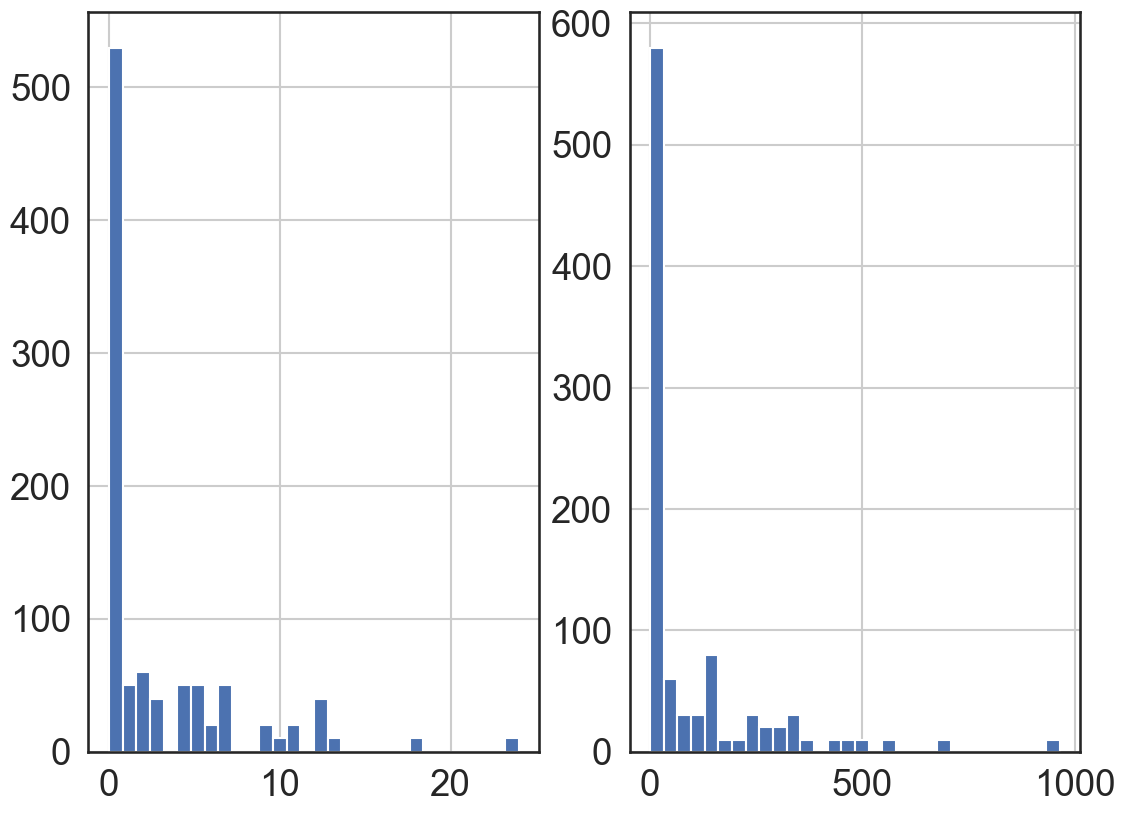

(100, 5)
(100, 10)
['mzuv' 'dsif' 'eles' 'dles' 'mfur' 'mgfz']
0 mzuv
1 dsif
2 eles
3 dles
4 mfur
5 mgfz


/home/ubuntu/tempnets/vis_utils.py:595: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f1f9e7cceb0> has a label of '_' which cannot be automatically added to the legend.
  fig.legend( labels=['Significance threshold \n(uncorrected)',
/home/ubuntu/tempnets/vis_utils.py:595: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f1f9cca5190> has a label of '_' which cannot be automatically added to the legend.
  fig.legend( labels=['Significance threshold \n(uncorrected)',
/home/ubuntu/tempnets/vis_utils.py:595: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f1f9ccbd130> has a label of '_' which cannot be automatically added to the legend.
  fig.legend( labels=['Significance threshold \n(uncorrected)',
/home/ubuntu/tempnets/vis_utils.py:595: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x7f1f9ccbd520> has a label of '_' which cannot be automatically added to the legend.
  fig.legend( labels=['Sig

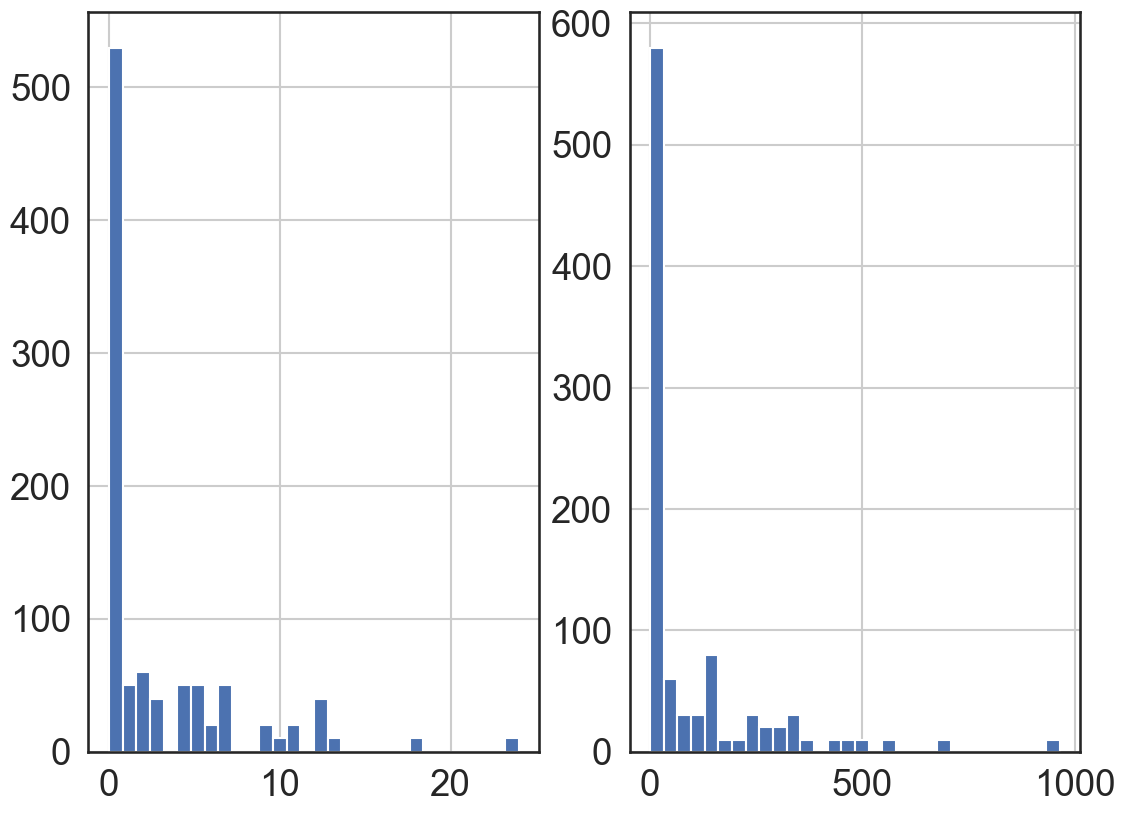

(100, 5)
(100, 10)
['mzuv' 'dsif' 'eles' 'dles' 'mfur' 'mgfz']
0 mzuv
1 dsif
2 eles
3 dles
4 mfur
5 mgfz


In [24]:
#plot_clustering('scalexdifficulty', 'topic', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
#                nperms=NPERMS)
plot_clustering('scalexdifficulty', 'matrix', model, train_data, df_item, device, FILENAME, minsamples=MINSAMPLES, 
                nperms=NPERMS)
#if DATASET in ['matrix', 'topic']:
#    sys.exit()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

[13.657305  10.983001   9.579306   6.7072353  5.944937   5.8555098
  5.32353    5.228452   4.7530675  4.684644   4.6604733  4.5873737
  4.5524178  4.547007   4.476936   4.458812 ]
[ 13.657305  24.640305  34.219612  40.926846  46.871784  52.727295
  58.050823  63.279278  68.03234   72.71699   77.377464  81.964836
  86.51726   91.06426   95.5412   100.000015]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

[28.825205  23.375698  18.320114  14.668473   6.6363425  3.9648094
  3.421125   0.7882351]
[ 28.825205  52.2009    70.52101   85.18948   91.82583   95.79064
  99.21176  100.      ]


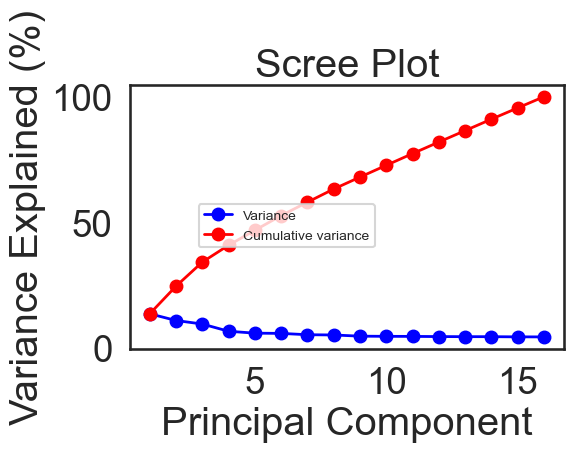

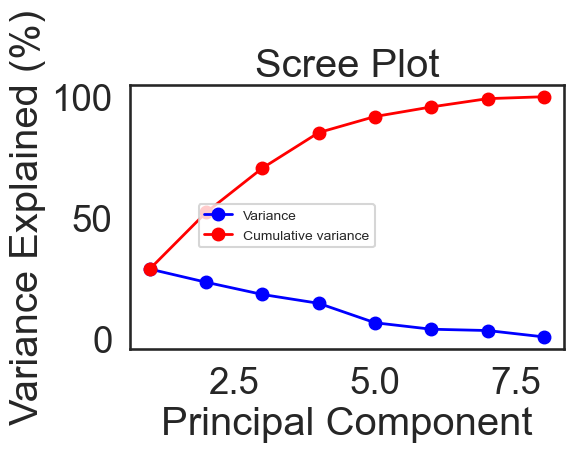

In [25]:
# represent embeddings before and after the GNN encoder
visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=False)

visualize_items(model, train_data, device, df_item.copy(), FILENAME, equal_axes=EQUAL_AXES, encoded=True)

In [26]:
#visualize_students(model, train_data, device, df_student, FILENAME, equal_axes=EQUAL_AXES)

In [27]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=True, aggregate=True, AGE_THR=AGE_THR)

In [28]:
#visualize_edges(model, train_data, train_edge_indices, device, df, FILENAME, 
#                equal_axes=EQUAL_AXES, with_lines=False, aggregate=False, AGE_THR=AGE_THR)

In [29]:
stophere

NameError: name 'stophere' is not defined

In [ ]:

from cluster_utils import compute_clustering_indices

from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

grouping_variable, target_variable = 'scalexdifficulty', 'topic'
scores_dict = {'CH': [], 'DB':[], 'N_LEVELS':[], 'N_SAMPLES':[]}
scores = compute_clustering_indices(model, train_data, df_item.copy(), device, grouping_variable, 
                                        target_variable, shuffle=False, seed=0, minsamples=MINSAMPLES)
[ scores_dict[key].append(scores[key]) for key in scores_dict]

scores_df = pd.DataFrame(scores_dict['DB'])        
scores_df = pd.melt(scores_df, value_name='index', var_name=grouping_variable).sort_values('index', ascending=False)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
def plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, k=0):
    df_item_ = df_item.reset_index().drop(columns='index')

    df_item_sub = df_item_.loc[df_item_[grouping_variable] == scores_df.iloc[k][grouping_variable]]
    df_item_sub

    dimred = PCA(whiten=False)
    z_dict = model.get_embeddings(data, encoded=True)
    embedding = z_dict['item'].detach().cpu().numpy()
    dimred.fit(embedding)

    low_dim = dimred.transform(embedding)
    low_dim = low_dim[df_item_sub.index, :]

    X = df_item_sub #.loc[select, :]

    #X['domain'] = X['domain'].apply(lambda x: DOMAIN_LABELS[x])

    X['x'] = low_dim[:, 0]
    X['y'] = low_dim[:, 1]
    X['z'] = low_dim[:, 2]

    fig = plt.figure(figsize=(15, 7))
    axes = sns.scatterplot(data=X, x='x', y='y', hue=target_variable, s=16, alpha=1) 
    axes.legend(prop = { 'size': 8 })
    plt.show()

    clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
    clustering.fit(low_dim)

    fig = plt.figure(figsize=(15, 7))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    plot_dendrogram(clustering, truncate_mode="level", p=5, labels=df_item_sub[target_variable].values)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    
for k in range(3):
    plot_clusters_slice(grouping_variable, target_variable, df_item, model, data, k=k)


In [ ]:

from cluster_utils import compute_clustering_indices

grouping_variable, target_variable = 'scalexdifficulty', 'matrix'
scores_dict = {'CH': [], 'DB':[], 'N_LEVELS':[], 'N_SAMPLES':[]}
scores = compute_clustering_indices(model, train_data, df_item.copy(), device, grouping_variable, 
                                        target_variable, shuffle=False, seed=0, minsamples=MINSAMPLES)
[ scores_dict[key].append(scores[key]) for key in scores_dict]

In [ ]:
scores_df = pd.DataFrame(scores_dict['DB'])        
scores_df = pd.melt(scores_df, value_name='index', var_name=grouping_variable).sort_values('index', ascending=False)
scores_df.iloc[0][grouping_variable]
df_item_ = df_item.reset_index().drop(columns='index')
df_item_sub = df_item_.loc[df_item_[grouping_variable] == scores_df.iloc[0][grouping_variable]]
df_item_sub



In [ ]:
from sklearn.decomposition import PCA
dimred = PCA(whiten=False)
df_item
z_dict = model.get_embeddings(data, encoded=True)
embedding = z_dict['item'].detach().cpu().numpy()
dimred.fit(embedding)

low_dim = dimred.transform(embedding)
low_dim = low_dim[df_item_sub.index, :]

X = df_item_sub #.loc[select, :]

#X['domain'] = X['domain'].apply(lambda x: DOMAIN_LABELS[x])

X['x'] = low_dim[:, 0]
X['y'] = low_dim[:, 1]
X['z'] = low_dim[:, 2]

import seaborn as sns
axes = sns.scatterplot(data=X, x='x', y='y', hue=target_variable, s=16, alpha=1) 
axes.legend(prop = { 'size': 8 })

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
clustering.fit(low_dim)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=5, labels=df_item_sub[target_variable].values)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [ ]:
def visualize_items(model, data, device, df_item, OUTNAME, dims=('x', 'y'), equal_axes=False, encoded=True):

    if encoded:
        suffix = ''    
    else:
        suffix = '_notenc'    
        
    data = data.to(device)
    try:
        pred, z_dict, z_edge = model(data)
    except:
        z_dict = model.get_embeddings(data, encoded=encoded)        
    embedding = z_dict['item'].detach().cpu().numpy()

    dimred.fit(embedding)
    low_dim = dimred.transform(embedding)

    X = df_item #.loc[select, :]
    
    X['domain'] = X['domain'].apply(lambda x: DOMAIN_LABELS[x])
    
    X['x'] = low_dim[:, 0]
    X['y'] = low_dim[:, 1]
    X['z'] = low_dim[:, 2]
    figname = f'{OUTNAME}_items{suffix}'
    save_plot(X, 'domain', 'Subject Domain', figname, x='x', y='y', plot_type='sct', equal_axes=equal_axes, with_legend=True)
    save_plot(X, 'scale', 'Competence Domain', figname, x='x', y='y', plot_type='sct', equal_axes=equal_axes)
    save_plot(X, 'IRT_difficulty', 'Difficulty', figname, x='x', y='y', plot_type='sct', equal_axes=equal_axes, palette='viridis')
    save_plot(X, 'IRT1_difficulty', 'Difficulty', figname, x='x', y='y', plot_type='sct', equal_axes=equal_axes, palette='viridis')
    save_plot(X, 'IRT1_discrimination', 'Discrimination', figname, x='x', y='y', plot_type='sct', equal_axes=equal_axes, palette='viridis')
    save_plot(X, 'IRT1_discrimination_transf', 'Discrimination (transformed)', figname, x='x', y='y', plot_type='sct', equal_axes=equal_axes, palette='viridis')

    save_plot(X, 'domain', 'Subject Domain', figname, x='z', y='y', plot_type='sct', equal_axes=equal_axes, with_legend=False)
    save_plot(X, 'scale', 'Competence Domain', figname, x='z', y='y', plot_type='sct', equal_axes=equal_axes)
    save_plot(X, 'IRT_difficulty', 'Difficulty', figname, x='z', y='y', plot_type='sct', equal_axes=equal_axes, palette='viridis')
    save_plot(X, 'IRT1_difficulty', 'Difficulty', figname, x='z', y='y', plot_type='sct', equal_axes=equal_axes, palette='viridis')
    save_plot(X, 'IRT1_discrimination', 'Discrimination', figname, x='z', y='y', plot_type='sct', equal_axes=equal_axes, palette='viridis')
    save_plot(X, 'IRT1_discrimination_transf', 'Discrimination (transformed)', figname, x='z', y='y', plot_type='sct', equal_axes=equal_axes, palette='viridis')

    figname = f'{OUTNAME}_dim_items{suffix}'
    for i, mydim in enumerate(['x', 'y', 'z']):
        save_plot(X, 'domain', 'Subject Domain', figname, x=mydim, plot_type='kde')
        save_plot(X, 'scale', 'Competence Domain', figname, x=mydim, plot_type='kde')
        save_plot(X, 'IRT_difficulty', 'Difficulty', figname, x=mydim, plot_type='reg')
        save_plot(X, 'IRT1_difficulty', 'Difficulty', figname, x=mydim, plot_type='reg')
        save_plot(X, 'IRT1_discrimination', 'Discrimination', figname, x=mydim, plot_type='reg')
        save_plot(X, 'IRT1_discrimination_transf', 'Discrimination (transformed)', figname, x=mydim, plot_type='reg')
        myresults.add_stats('item_difficulty_%s'%mydim, X['IRT_difficulty'], X[mydim])
        myresults.add_stats('item_difficulty1_%s'%mydim, X['IRT1_difficulty'], X[mydim])
        myresults.add_stats('item_discrimination1_%s'%mydim, X['IRT1_discrimination'], X[mydim])
        
    fig = plt.figure()
    PC_values = np.arange(dimred.n_components_) + 1
    #plt.sca(axes[1, 1])
    plt.plot(PC_values, dimred.explained_variance_ratio_*100, 'o-', linewidth=2, color='blue')
    plt.plot(PC_values, np.cumsum(dimred.explained_variance_ratio_)*100, 'o-', linewidth=2, color='red')
    fig.legend(labels=['Variance', 'Cumulative variance'], loc='center', fontsize=10)
    
    print(dimred.explained_variance_ratio_*100)
    print(np.cumsum(dimred.explained_variance_ratio_)*100)
    
    if MAX_PCS > 0:
        plt.xticks(PC_values[:MAX_PCS])
        plt.xlim(0, max(PC_values[:MAX_PCS])+1)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    fig.tight_layout()
    
    plt.savefig(f'./vis/{OUTNAME}_items_PCA{suffix}.png', dpi=DPI)


df_item.query("scale=='dsif'").groupby('scalexdifficulty').matrix.count().sort_values(ascending=False)

from cluster_utils import compute_clustering_indices

grouping_variable = 'scalexdifficulty'
target_variable = 'matrix'
minsamples = 10
scores_dict = {'CH': [], 'DB':[], 'N_LEVELS':[], 'N_SAMPLES':[]}

for perm in range(NPERMS):
    print(perm)
    scores = compute_clustering_indices(model, train_data, df_item, device, grouping_variable, 
                                        target_variable, shuffle=perm>0, seed=0, minsamples=minsamples)
    [ scores_dict[key].append(scores[key]) for key in scores_dict]

scores_df = pd.DataFrame(scores_dict['CH'])
scores_df['perm'] = scores_df.index     
scores_df = pd.melt(scores_df, id_vars='perm', value_name='index', var_name=grouping_variable)

scores_df['N_LEVELS'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_LEVELS'][0][x])
scores_df['N_SAMPLES'] = scores_df[grouping_variable].apply(lambda x: scores_dict['N_SAMPLES'][0][x])

fig = plt.subplots(ncols=2, nrows=1)
ax = plt.subplot(1, 2, 1)
scores_df['N_LEVELS'].hist(ax=ax, bins=30)
ax = plt.subplot(1, 2, 2)
scores_df['N_SAMPLES'].hist(ax=ax, bins=30)        
plt.show()
plt.close()